<a href="https://colab.research.google.com/github/GiovanniPioDelvecchio/GCNs_on_text/blob/issue%232/GNN_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install stanza
!pip install torch-geometric
!pip install torchsummary
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 933.2/933.2 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.3 MB/s eta 0:00:00


In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)
import utils

In [2]:
!git clone https://github.com/GiovanniPioDelvecchio/GCNs_on_text.git
%cd GCNs_on_text
!git checkout issue-#5

Cloning into 'GCNs_on_text'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 103 (delta 46), reused 54 (delta 16), pack-reused 0
Receiving objects: 100% (103/103), 6.03 MiB | 12.71 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/GCNs_on_text
Branch 'issue-#5' set up to track remote branch 'issue-#5' from 'origin'.
Switched to a new branch 'issue-#5'


In [3]:
import utils
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import save, load
import torch.nn as nn
from torchsummary import summary

from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, InMemoryDataset
from torch_geometric.utils import scatter
from torch_geometric.data import download_url

from torch_geometric.nn import GCNConv, GATv2Conv, global_mean_pool
import torch.nn.functional as F
from torch.nn import Linear, Dropout

from functools import partial
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import PolynomialLR
from torch_geometric.nn.pool import global_max_pool
from torch.optim.lr_scheduler import OneCycleLR

INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                  |
| pos       | combined_charlm           |
| lemma     | combined_nocharlm         |
| depparse  | combined_charlm           |
| ner       | ontonotes-ww-multi_charlm |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


glove path missing
saving directory missing


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Utils have been correctly loaded


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
tweet_list_train = []
sentiment_list_train = []
tweet_list_val = []
sentiment_list_val = []
tweet_list_test = []
sentiment_list_test = []
cv19_graph_data_train = utils.Dataset_from_sentences("train", "/content/processed_train/",
                                                     "/content/drive/MyDrive/glove_twitter_100_unnormalized/train/",
                                                     tweet_list_train, sentiment_list_train)
cv19_graph_data_val = utils.Dataset_from_sentences("val", "/content/processed_val/",
                                                     "/content/drive/MyDrive/glove_twitter_100_unnormalized/val/",
                                                     tweet_list_train, sentiment_list_train)
cv19_graph_data_test = utils.Dataset_from_sentences("test", "/content/processed_test/",
                                                    "/content/drive/MyDrive/glove_twitter_100_unnormalized/test/",
                                                    tweet_list_test, sentiment_list_test)

print("Loaded training dataset:")
print(cv19_graph_data_train)
print("Loaded val dataset:")
print(cv19_graph_data_val)
print("Loaded test dataset:")
print(cv19_graph_data_test)

['/content/processed_train//train.pt']
['/content/processed_val//val.pt']
['/content/processed_test//test.pt']
Loaded training dataset:
Dataset_from_sentences(25534)
Loaded val dataset:
Dataset_from_sentences(6384)
Loaded test dataset:
Dataset_from_sentences(7980)


In [ ]:
tweet_list_train = []
sentiment_list_train = []
tweet_list_val = []
sentiment_list_val = []
tweet_list_test = []
sentiment_list_test = []
cv19_bert_data_train = utils.Dataset_from_sentences("train", "/content/processed_train/",
                                                     "/content/drive/MyDrive/GraphDataset/train/",
                                                     tweet_list_train, sentiment_list_train)
cv19_bert_data_val = utils.Dataset_from_sentences("val", "/content/processed_val/",
                                                     "/content/drive/MyDrive/GraphDataset/val/",
                                                     tweet_list_train, sentiment_list_train)
cv19_bert_data_test = utils.Dataset_from_sentences("test", "/content/processed_test/",
                                                    "/content/drive/MyDrive/GraphDataset/test/",
                                                    tweet_list_test, sentiment_list_test)

print("Loaded training dataset:")
print(cv19_bert_data_train)
print("Loaded val dataset:")
print(cv19_bert_data_val)
print("Loaded test dataset:")
print(cv19_bert_data_test)

['/content/processed_train//train.pt']
['/content/processed_val//val.pt']
['/content/processed_test//test.pt']
Loaded training dataset:
Dataset_from_sentences(25534)
Loaded val dataset:
Dataset_from_sentences(6384)
Loaded test dataset:
Dataset_from_sentences(7980)


In [ ]:
# GCN definition
class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, n_filters, dim_out):
    super().__init__()

    self.first_linear = Linear(dim_in, dim_in)

    self.gcn_list_1 = torch.nn.ModuleList([GCNConv(dim_in, dim_in, add_self_loops = True)
                                         for i in range(0, n_filters)])
    self.gcn_list_2 = torch.nn.ModuleList([GCNConv(dim_in, dim_in, add_self_loops = True)
                                         for i in range(0, n_filters)])
    self.gcn_list_3 = torch.nn.ModuleList([GCNConv(dim_in, dim_in, add_self_loops = True)
                                         for i in range(0, n_filters)])

    #self.gcn_1 = GCNConv(dim_in, dim_in, add_self_loops = True)
    #self.gcn_2 = GCNConv(dim_in, dim_in, add_self_loops = True)
    #self.gcn_3 = GCNConv(dim_in, dim_in, add_self_loops = True)
    self.l_list = torch.nn.ModuleList([Linear(dim_in, 1)
                                      for i in range(0, n_filters)])
    self.classifier = Linear(n_filters, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=1e-3,
                                      weight_decay=5e-5)

  def forward(self, x, edge_index, batch, enable_log = False):
    # the parameters of the forward correspond to data.x and data.edge_index
    # where data is a Data object like those described above;
    if enable_log:
        utils.visualize_hidden_graph(x, edge_index)

    #h = self.first_linear(x)

    h_list = []
    for i, gcn_l in enumerate(self.gcn_list_1):
        h = x + gcn_l(x, edge_index)
        h = h.tanh()
        h = h + self.gcn_list_2[i](h, edge_index)
        h = h.tanh()
        h = h + self.gcn_list_3[i](h, edge_index)
        if enable_log:
            print("h shape: " + str(h.shape))
            utils.visualize_hidden_graph(h, edge_index)
        h = global_mean_pool(h, batch)
        h = self.l_list[i](h)
        h_list.append(h)

    h_layers = torch.hstack(h_list)
    #print(h_layers.shape)
    h_layers = self.classifier(h_layers)


    """
    h = self.first_linear(x)
    h = h + self.gcn_1(h, edge_index)
    h = h + self.gcn_2(h, edge_index)
    h = h + self.gcn_3(h, edge_index)
    if enable_log:
        visualize_hidden_graph(x, edge_index)
    h = global_mean_pool(h, batch)
    h = self.classifier(h)
    """

    return h_layers

In [ ]:
# actual GAT class
class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, n_filters, dim_out, heads= 8):
    super().__init__()
    # dim_in is the number of node features, dim_h is the dimension
    # of the hidden layer, dim_out is the dimension of the output
    # feature vector
    self.first_linear = Linear(dim_in, dim_in)

    self.gat_list_1 = torch.nn.ModuleList([GATv2Conv(dim_in, dim_in // heads, heads = heads)
                                         for i in range(0, n_filters)])
    self.gat_list_2 = torch.nn.ModuleList([GATv2Conv(dim_in, dim_in // heads, heads = heads)
                                         for i in range(0, n_filters)])
    self.gat_list_3 = torch.nn.ModuleList([GATv2Conv(dim_in, dim_in // heads, heads = heads)
                                         for i in range(0, n_filters)])

    self.l_list = torch.nn.ModuleList([Linear(dim_in, 1)
                                      for i in range(0, n_filters)])
    self.classifier = Linear(n_filters, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=1e-3,
                                      weight_decay=5e-5)

  def forward(self, x, edge_index, batch, enable_log = False):
    print(x.shape)
    # the parameters of the forward correspond to data.x and data.edge_index
    # where data is a Data object like those described above;
    if enable_log:
        utils.visualize_hidden_graph(x, edge_index)

    #h = self.first_linear(x)

    h_list = []
    for i, gat_l in enumerate(self.gat_list_1):
        #print(f"shape of initial tensor x: {x.shape}")
        h = x + gat_l(x, edge_index)
        #print(f"shape of the first residual: {h.shape}")
        h = h.tanh()
        h = h + self.gat_list_2[i](h, edge_index)
        #print(f"shape of the second residual: {h.shape}")
        h = h.tanh()
        h = h + self.gat_list_3[i](h, edge_index)
        #print(f"shape of the third residual: {h.shape}")
        if enable_log:
            print("h shape: " + str(h.shape))
            utils.visualize_hidden_graph(h, edge_index)
        h = global_mean_pool(h, batch)
        #print(f"shape of the tensor after global mean pool: {h.shape}")
        h = self.l_list[i](h)
        h_list.append(h)

    h_layers = torch.hstack(h_list)
    #print(h_layers.shape)
    h_layers = self.classifier(h_layers)
    return h_layers

In [8]:
# actual GAT class
class GAT_lstm(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, n_filters, dim_out, heads= 8):
    super().__init__()
    # dim_in is the number of node features, dim_h is the dimension
    # of the hidden layer, dim_out is the dimension of the output
    # feature vector


    #self.first_linear = Linear(dim_in, dim_in)

    self.gat_list_1 = torch.nn.ModuleList([GATv2Conv(dim_in, dim_in // heads, heads = heads)
                                         for i in range(0, n_filters)])
    self.gat_list_2 = torch.nn.ModuleList([GATv2Conv(dim_in, dim_in // heads, heads = heads)
                                         for i in range(0, n_filters)])
    self.gat_list_3 = torch.nn.ModuleList([GATv2Conv(dim_in, dim_in // heads, heads = heads)
                                         for i in range(0, n_filters)])

    self.l_list = torch.nn.ModuleList([Linear(dim_in, 1)
                                      for i in range(0, n_filters)])

    self.h0 = torch.randn(1, dim_in)
    self.c0 = torch.randn(1, dim_in)
    self.h0 = self.h0.to(device)
    self.c0 = self.c0.to(device)
    self.lstm = nn.LSTM(dim_in, dim_in, num_layers = 1, dropout = 0, bidirectional = False)
    self.classifier = Linear(n_filters, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=1e-3,
                                      weight_decay=5e-5)

  def forward(self, x, edge_index, batch, enable_log = False):
    # the parameters of the forward correspond to data.x and data.edge_index
    # where data is a Data object like those described above;
    stack_list = []
    batch_elements = batch.unique()
    for elem in batch_elements:
      idxs = torch.where(batch == elem)
      current_graph = x[idxs]
      self.lstm.flatten_parameters()
      to_stack, (hn, cn) = self.lstm(current_graph, (self.h0, self.c0))
      stack_list.append(to_stack)

    h_to_gat = torch.vstack(stack_list)
    #print(h_to_gat.shape)
    #print(x.shape)

    #h_stacked = global_mean_pool(h_stacked, batch)
    #h_stacked = self.classifier(h_stacked)

    h_list = []
    for i, gat_l in enumerate(self.gat_list_1):
        h = h_to_gat + gat_l(h_to_gat, edge_index)
        h = h.tanh()
        h = h + self.gat_list_2[i](h, edge_index)
        h = h.tanh()
        h = h + self.gat_list_3[i](h, edge_index)
        if enable_log:
            print("h shape: " + str(h.shape))
            utils.visualize_hidden_graph(h, edge_index)
        h = global_mean_pool(h, batch)
        h = self.l_list[i](h)
        h_list.append(h)

    h_layers = torch.hstack(h_list)
    h_layers = self.classifier(h_layers)
    return h_layers

In [ ]:
# actual GAT class
class GAT_bilstm(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in,  n_filters, dim_out,dim_out_lstm = None, heads= 8):
    super().__init__()
    # dim_in is the number of node features, dim_h is the dimension
    # of the hidden layer, dim_out is the dimension of the output
    # feature vector

    if dim_out_lstm == None:
      dim_out_lstm = dim_in

    #self.first_linear = Linear(dim_in, dim_in)
    if ((dim_in * 2) % heads) != 0:
      raise ValueError(f"Number of input dimensions*2 must be divisible by the number of heads")
    self.gat_list_1 = torch.nn.ModuleList([GATv2Conv(dim_out_lstm * 2, (dim_out_lstm * 2) // heads, heads = heads)
                                         for i in range(0, n_filters)])
    self.gat_list_2 = torch.nn.ModuleList([GATv2Conv(dim_out_lstm * 2, (dim_out_lstm * 2) // heads, heads = heads)
                                         for i in range(0, n_filters)])
    self.gat_list_3 = torch.nn.ModuleList([GATv2Conv(dim_out_lstm * 2, (dim_out_lstm * 2) // heads, heads = heads)
                                         for i in range(0, n_filters)])

    self.l_list = torch.nn.ModuleList([Linear(dim_out_lstm * 2, 1)
                                      for i in range(0, n_filters)])

    self.h0 = torch.randn(2, dim_out_lstm)
    self.c0 = torch.randn(2, dim_out_lstm)
    self.h0 = self.h0.to(device)
    self.c0 = self.c0.to(device)
    self.lstm = nn.LSTM(dim_in, dim_out_lstm, num_layers = 1, dropout = 0, bidirectional = True)
    self.classifier = Linear(n_filters, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=1e-3,
                                      weight_decay=5e-5)

  def forward(self, x, edge_index, batch, enable_log = False):
    # the parameters of the forward correspond to data.x and data.edge_index
    # where data is a Data object like those described above;
    stack_list = []
    batch_elements = batch.unique()
    for elem in batch_elements:
      idxs = torch.where(batch == elem)
      current_graph = x[idxs]
      self.lstm.flatten_parameters()
      to_stack, (hn, cn) = self.lstm(current_graph, (self.h0, self.c0))
      stack_list.append(to_stack)

    h_to_gat = torch.vstack(stack_list)
    #print(h_to_gat.shape)
    #print(x.shape)

    #h_stacked = global_mean_pool(h_stacked, batch)
    #h_stacked = self.classifier(h_stacked)

    h_list = []
    for i, gat_l in enumerate(self.gat_list_1):
        h = h_to_gat +  gat_l(h_to_gat, edge_index)
        h = h.tanh()
        h = h + self.gat_list_2[i](h, edge_index)
        h = h.tanh()
        h = h + self.gat_list_3[i](h, edge_index)
        if enable_log:
            print("h shape: " + str(h.shape))
            utils.visualize_hidden_graph(h, edge_index)
        h = global_mean_pool(h, batch)
        h = self.l_list[i](h)
        h_list.append(h)

    h_layers = torch.hstack(h_list)
    h_layers = self.classifier(h_layers)
    return h_layers

In [9]:
class EarlyStopper:
  def __init__(self, patience=1, min_delta=0):
      self.patience = patience
      self.min_delta = min_delta
      self.counter = 0
      self.min_validation_loss = np.inf

  def early_stop(self, validation_loss):
      if validation_loss < self.min_validation_loss:
          self.min_validation_loss = validation_loss
          self.counter = 0
      elif validation_loss > (self.min_validation_loss + self.min_delta):
          self.counter += 1
          if self.counter >= self.patience:
              return True
      return False

def plot_losses(train_losses, val_losses):
    """
    Plots the training and validation losses over the course of training.
    Args:
        train_losses: A list of training losses.
        val_losses: A list of validation losses.
    """
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

In [10]:
import time
def train(model, strat_train, strat_val, partial_scheduler, epochs = 30, batch_size = 30, print_every = 1, path='Model'):
    """Train a GNN model and return the trained model."""
    batch_size = batch_size
    criterion = torch.nn.CrossEntropyLoss(label_smoothing = 0.01)
    optimizer = model.optimizer
    scheduler = partial_scheduler(optimizer)
    print(type(scheduler))
    loader_train =  DataLoader(strat_train.data_list, batch_size=batch_size, shuffle=True)
    loader_val = DataLoader(strat_val.data_list, batch_size=batch_size, shuffle=True)
    model.train()
    early_stopper = EarlyStopper(patience=10, min_delta=0.2)

    train_losses = []
    val_losses = []

    best_model = []
    best_acc_val = 0
    epochs_to_return = 0
    start_t = time.time()
    #scheduler.step()
    for epoch in range(epochs+1):
      mean_loss_train = 0
      mean_acc_train = 0
      for i, batch in enumerate(loader_train):
        # Training

        out = model(batch.x.to(device), batch.edge_index.to(device), batch.batch.to(device))
        loss_train = criterion(out, batch.y.long().to(device))
        mean_loss_train += loss_train.item()

        acc_train = accuracy(out.argmax(dim=1), batch.y.to(device))
        mean_acc_train += acc_train
        loss_train.backward()
        with torch.no_grad():
            optimizer.step()
            if type(scheduler) == OneCycleLR:
                scheduler.step()
            optimizer.zero_grad()
      print(i)
      mean_loss_train /= (i + 1)
      mean_acc_train /= (i + 1)
      train_losses.append(mean_loss_train)
      if type(scheduler) != OneCycleLR:
          scheduler.step()

      mean_loss_val = 0
      mean_acc_val = 0
      #model.eval()
      with torch.no_grad():
          for i, batch in enumerate(loader_val):
            out = model(batch.x.to(device), batch.edge_index.to(device), batch.batch.to(device))
            loss_val = criterion(out, batch.y.long().to(device))
            mean_loss_val += loss_val.item()
            acc_val = accuracy(out.argmax(dim=1), batch.y.to(device))
            mean_acc_val += acc_val
            #visualize_embedding(embed, batch.y, epoch, loss_val)
          mean_loss_val /= (i + 1)
          mean_acc_val /= (i + 1)
          val_losses.append(mean_loss_val)
          if mean_acc_val > best_acc_val:
                best_acc_val = mean_acc_val
                best_model = copy.deepcopy(model)
                epochs_to_return = epoch
          if epoch % 15 == 0 and epoch > 0:
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': model.optimizer.state_dict(),
            'loss': mean_loss_train,
            }, path + '_ckpt')
       # model.train()

      if(epoch % print_every == 0):
        print(f'Epoch {epoch:>3} | Train Loss: {mean_loss_train:.3f} | Train Acc: '
              f'{mean_acc_train*100:>6.2f}%')
        print(f'Epoch {epoch:>3} | Val Loss: {mean_loss_val:.3f} | Val Acc: '
              f'{mean_acc_val*100:>6.2f}%')
        print("learning rate: " + str(scheduler.get_last_lr()))
        print("elapsed time: %.2f" % (time.time()-start_t))
        start_t = time.time()
      if early_stopper.early_stop(mean_loss_val):
        print("early stopping was triggered, final loss:" + str(mean_loss_val))
        break
    plot_losses(train_losses, val_losses)
    return best_model, best_acc_val, epochs_to_return

In [11]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def build_scheduler_list(epochs = 30, max_lr = 1e-3, num_batches = 1):
    schedulers = []

    #schedulers += [partial(PolynomialLR,
    #                     total_iters = epochs, # The number of steps that the scheduler decays the learning rate.
    #                     power = i) for i in range(2, 3)] # The power of the polynomial. # 2 to 1
    schedulers += [partial(StepLR,
                                  step_size=epochs//i, gamma=0.5) for i in range(3, 4)] # for i in range(3, 5)
    schedulers += [partial(CosineAnnealingLR,
                              T_max = epochs, # Maximum number of iterations.
                              eta_min = min_lr) for min_lr in [1e-8]] # Minimum learning rate, tested values were 1e-6, 1e-7, 1e-8
    #schedulers += [partial(OneCycleLR,
    #                   max_lr = max_lr, # Upper learning rate boundaries in the cycle for each parameter group
    #                   steps_per_epoch = num_batches, # The number of steps per epoch to train for.
    #                   epochs = epochs, # The number of epochs to train for.
    #                   anneal_strategy = 'cos')] # Specifies the annealing strategy
    return schedulers

In [12]:
def hyperparameter_tuning(model, strat_train, strat_val, scheduler_list, batch_size = 30, epochs = 30):
    print(f"batch size: {batch_size}")
    best_valid_acc = 0
    best_model = []
    best_hyper_params = []
    best_val_acc = 0
    i = 1
    for partial_scheduler in scheduler_list:
        path = f'/content/drive/MyDrive/graphmod/GAT_best_{partial_scheduler.func.__name__}_{i}'
        model_out, mean_acc_val, epoch = train(copy.deepcopy(model), strat_train, strat_val,
                                               partial_scheduler, epochs, batch_size = batch_size, print_every=1, path=path)
        torch.save(model_out,path)
        if mean_acc_val > best_val_acc:
            best_val_acc = mean_acc_val
            best_model = model_out
            best_hyper_params = [partial_scheduler, epoch]
            print(f"Improved result: acc {best_val_acc:.3f}, scheduler:\n {partial_scheduler}\nepoch: {epoch}")
        i = i + 1
    return best_hyper_params, best_model

In [ ]:
#BERT MOMENTO
model_bertgat = GAT_bilstm(cv19_bert_data_train.num_node_features,
                cv19_bert_data_train.num_classes*2,
                cv19_bert_data_train.num_classes,
                dim_out_lstm=cv19_bert_data_train.num_node_features//4,
                heads = 12).to(device)
print(model_bertgat)

GAT_bilstm(
  (gat_list_1): ModuleList(
    (0-9): 10 x GATv2Conv(384, 32, heads=12)
  )
  (gat_list_2): ModuleList(
    (0-9): 10 x GATv2Conv(384, 32, heads=12)
  )
  (gat_list_3): ModuleList(
    (0-9): 10 x GATv2Conv(384, 32, heads=12)
  )
  (l_list): ModuleList(
    (0-9): 10 x Linear(in_features=384, out_features=1, bias=True)
  )
  (lstm): LSTM(768, 192, bidirectional=True)
  (classifier): Linear(in_features=10, out_features=5, bias=True)
)


0.001
[functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=300, power=2), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=100, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=75, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-06), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-07), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-08), functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>, max_lr=0.001, steps_per_epoch=103, epochs=300, anneal_strategy='cos')]
batch size: 256
<class 'torch.optim.lr_scheduler.PolynomialLR'>
99
Epoch   0 | Train Loss: 1.365 | Train Acc:  39.78%
Epoch   0 | Val Loss: 1.237 | Val Acc:  46.07%
learning rate: [0.0009933444444444445]
elapsed time: 124.02
99
Epoch   1 | Train Loss: 1.170 | Train Acc:  50.06%
Epoch   1 | 

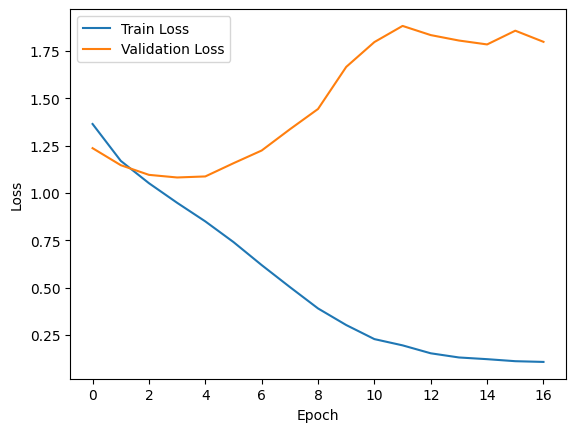

Improved result: acc 0.578, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=300, power=2)
epoch: 11
<class 'torch.optim.lr_scheduler.StepLR'>
99
Epoch   0 | Train Loss: 1.343 | Train Acc:  41.23%
Epoch   0 | Val Loss: 1.221 | Val Acc:  47.06%
learning rate: [0.001]
elapsed time: 124.93
99
Epoch   1 | Train Loss: 1.170 | Train Acc:  49.69%
Epoch   1 | Val Loss: 1.152 | Val Acc:  51.32%
learning rate: [0.001]
elapsed time: 124.06
99
Epoch   2 | Train Loss: 1.057 | Train Acc:  55.55%
Epoch   2 | Val Loss: 1.082 | Val Acc:  54.53%
learning rate: [0.001]
elapsed time: 124.07
99
Epoch   3 | Train Loss: 0.952 | Train Acc:  61.29%
Epoch   3 | Val Loss: 1.062 | Val Acc:  55.84%
learning rate: [0.001]
elapsed time: 123.58
99
Epoch   4 | Train Loss: 0.851 | Train Acc:  66.34%
Epoch   4 | Val Loss: 1.069 | Val Acc:  57.33%
learning rate: [0.001]
elapsed time: 123.65
99
Epoch   5 | Train Loss: 0.749 | Train Acc:  71.53%
Epoch   5 | Val Loss: 1.138 | Val Ac

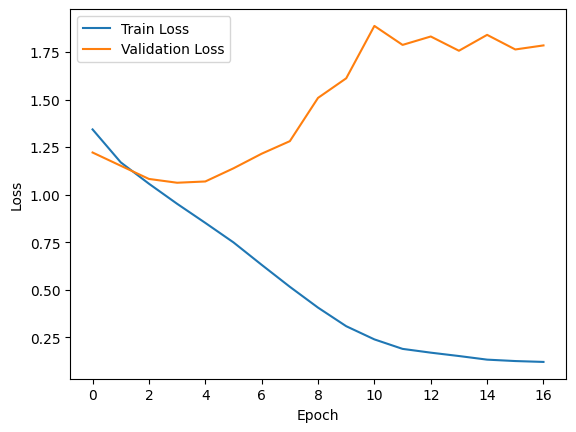

Improved result: acc 0.582, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=100, gamma=0.5)
epoch: 9
<class 'torch.optim.lr_scheduler.StepLR'>
99
Epoch   0 | Train Loss: 1.362 | Train Acc:  39.75%
Epoch   0 | Val Loss: 1.239 | Val Acc:  46.30%
learning rate: [0.001]
elapsed time: 123.78
99
Epoch   1 | Train Loss: 1.175 | Train Acc:  49.83%
Epoch   1 | Val Loss: 1.152 | Val Acc:  50.75%
learning rate: [0.001]
elapsed time: 124.17
99
Epoch   2 | Train Loss: 1.074 | Train Acc:  55.00%
Epoch   2 | Val Loss: 1.098 | Val Acc:  54.14%
learning rate: [0.001]
elapsed time: 123.58
99
Epoch   3 | Train Loss: 0.960 | Train Acc:  60.90%
Epoch   3 | Val Loss: 1.079 | Val Acc:  56.49%
learning rate: [0.001]
elapsed time: 124.30
99
Epoch   4 | Train Loss: 0.869 | Train Acc:  65.35%
Epoch   4 | Val Loss: 1.046 | Val Acc:  57.29%
learning rate: [0.001]
elapsed time: 123.86
99
Epoch   5 | Train Loss: 0.747 | Train Acc:  71.49%
Epoch   5 | Val Loss: 1.134 | Val Acc:  56.

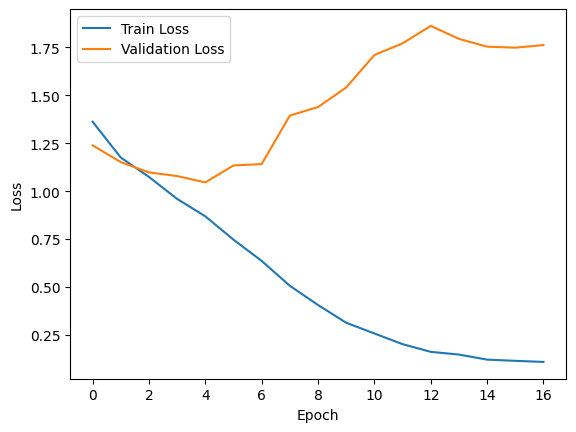

<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
99
Epoch   0 | Train Loss: 1.364 | Train Acc:  39.93%
Epoch   0 | Val Loss: 1.239 | Val Acc:  46.62%
learning rate: [0.0009999726120980734]
elapsed time: 124.53
99
Epoch   1 | Train Loss: 1.168 | Train Acc:  50.05%
Epoch   1 | Val Loss: 1.146 | Val Acc:  51.77%
learning rate: [0.0009998904513956854]
elapsed time: 124.23
99
Epoch   2 | Train Loss: 1.054 | Train Acc:  56.02%
Epoch   2 | Val Loss: 1.081 | Val Acc:  54.74%
learning rate: [0.0009997535269026829]
elapsed time: 123.84
99
Epoch   3 | Train Loss: 0.947 | Train Acc:  61.54%
Epoch   3 | Val Loss: 1.051 | Val Acc:  56.90%
learning rate: [0.0009995618536343797]
elapsed time: 124.10
99
Epoch   4 | Train Loss: 0.849 | Train Acc:  66.52%
Epoch   4 | Val Loss: 1.055 | Val Acc:  58.99%
learning rate: [0.0009993154526099096]
elapsed time: 124.44
99
Epoch   5 | Train Loss: 0.745 | Train Acc:  71.94%
Epoch   5 | Val Loss: 1.086 | Val Acc:  57.92%
learning rate: [0.0009990143508499217]
el

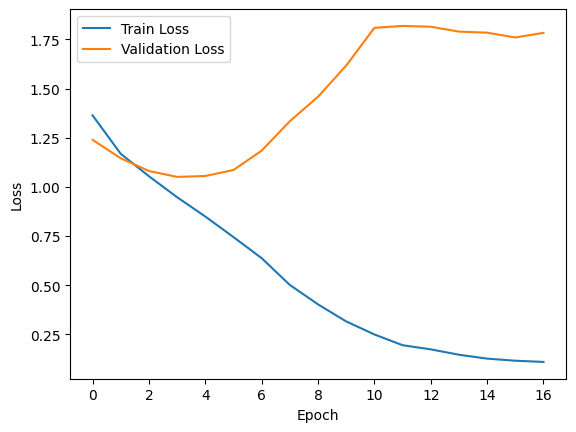

Improved result: acc 0.590, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-06)
epoch: 4
<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
99
Epoch   0 | Train Loss: 1.361 | Train Acc:  39.77%
Epoch   0 | Val Loss: 1.229 | Val Acc:  47.23%
learning rate: [0.0009999725874242878]
elapsed time: 123.57
99
Epoch   1 | Train Loss: 1.170 | Train Acc:  49.67%
Epoch   1 | Val Loss: 1.196 | Val Acc:  48.99%
learning rate: [0.000999890352703249]
elapsed time: 123.29
99
Epoch   2 | Train Loss: 1.061 | Train Acc:  55.71%
Epoch   2 | Val Loss: 1.076 | Val Acc:  55.29%
learning rate: [0.0009997533048548475]
elapsed time: 124.84
99
Epoch   3 | Train Loss: 0.960 | Train Acc:  61.20%
Epoch   3 | Val Loss: 1.070 | Val Acc:  56.32%
learning rate: [0.0009995614589079242]
elapsed time: 123.45
99
Epoch   4 | Train Loss: 0.850 | Train Acc:  66.71%
Epoch   4 | Val Loss: 1.089 | Val Acc:  55.29%
learning rate: [0.0009993148359005491]
elapsed time: 123

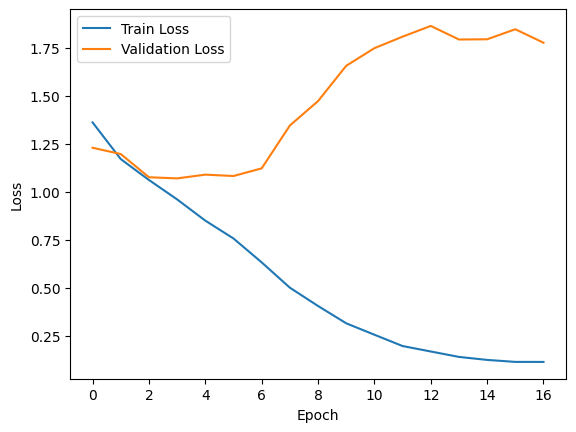

Improved result: acc 0.596, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-07)
epoch: 6
<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
99
Epoch   0 | Train Loss: 1.348 | Train Acc:  40.76%
Epoch   0 | Val Loss: 1.232 | Val Acc:  46.62%
learning rate: [0.0009999725849569093]
elapsed time: 124.93
99
Epoch   1 | Train Loss: 1.165 | Train Acc:  49.92%
Epoch   1 | Val Loss: 1.149 | Val Acc:  51.90%
learning rate: [0.0009998903428340053]
elapsed time: 124.25
99
Epoch   2 | Train Loss: 1.056 | Train Acc:  55.99%
Epoch   2 | Val Loss: 1.075 | Val Acc:  55.77%
learning rate: [0.0009997532826500639]
elapsed time: 124.87
99
Epoch   3 | Train Loss: 0.961 | Train Acc:  60.66%
Epoch   3 | Val Loss: 1.074 | Val Acc:  55.37%
learning rate: [0.0009995614194352785]
elapsed time: 124.18
99
Epoch   4 | Train Loss: 0.859 | Train Acc:  65.84%
Epoch   4 | Val Loss: 1.055 | Val Acc:  58.15%
learning rate: [0.000999314774229613]
elapsed time: 125

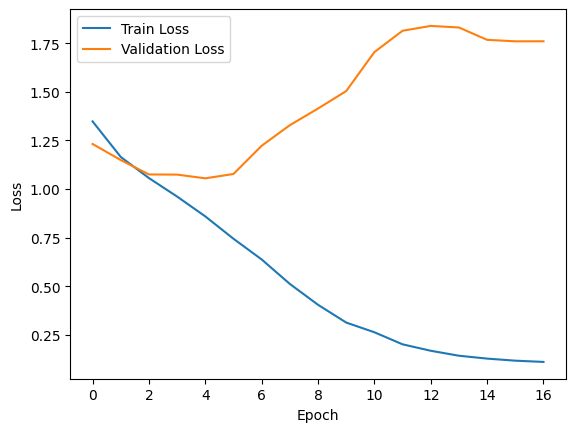

<class 'torch.optim.lr_scheduler.OneCycleLR'>
99
Epoch   0 | Train Loss: 1.501 | Train Acc:  32.40%
Epoch   0 | Val Loss: 1.418 | Val Acc:  37.52%
learning rate: [4.027567897599423e-05]
elapsed time: 124.91
99
Epoch   1 | Train Loss: 1.376 | Train Acc:  40.05%
Epoch   1 | Val Loss: 1.333 | Val Acc:  41.98%
learning rate: [4.110239924190267e-05]
elapsed time: 124.46
99
Epoch   2 | Train Loss: 1.295 | Train Acc:  43.98%
Epoch   2 | Val Loss: 1.280 | Val Acc:  44.36%
learning rate: [4.24792111752407e-05]
elapsed time: 124.29
99
Epoch   3 | Train Loss: 1.246 | Train Acc:  46.14%
Epoch   3 | Val Loss: 1.259 | Val Acc:  45.56%
learning rate: [4.440453328390852e-05]
elapsed time: 124.09
99
Epoch   4 | Train Loss: 1.223 | Train Acc:  47.68%
Epoch   4 | Val Loss: 1.243 | Val Acc:  46.88%
learning rate: [4.687615402279219e-05]
elapsed time: 123.89
99
Epoch   5 | Train Loss: 1.196 | Train Acc:  49.10%
Epoch   5 | Val Loss: 1.225 | Val Acc:  47.71%
learning rate: [4.989123433408191e-05]
elapsed ti

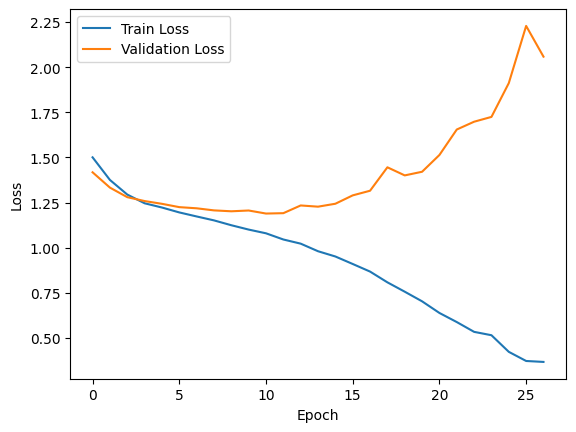

In [ ]:
epochs = 300
batch_size = 256
print(get_lr(model_bertgat.optimizer))
scheduler_list = build_scheduler_list(epochs=epochs,
                                      num_batches=(len(cv19_bert_data_train.data_list)//batch_size) + 4)
print(scheduler_list)
trained_gat = hyperparameter_tuning(model_bertgat, cv19_bert_data_train,
                                    cv19_bert_data_val, scheduler_list,
                                    batch_size = batch_size, epochs = epochs)

In [ ]:
#cv19_bert_data_train = cv19_bert_data_train.to(device)
#cv19_bert_data_val = cv19_bert_data_val.to(device)

In [ ]:
cv19_graph_data_train = cv19_graph_data_train.to(device)
cv19_graph_data_val = cv19_graph_data_val.to(device)

In [ ]:
model_gcn = GCN(cv19_graph_data_train.num_node_features,
                cv19_graph_data_train.num_classes*2,
                cv19_graph_data_train.num_classes).to(device)
print(model_gcn)

GCN(
  (first_linear): Linear(in_features=50, out_features=50, bias=True)
  (gcn_list_1): ModuleList(
    (0-9): 10 x GCNConv(50, 50)
  )
  (gcn_list_2): ModuleList(
    (0-9): 10 x GCNConv(50, 50)
  )
  (gcn_list_3): ModuleList(
    (0-9): 10 x GCNConv(50, 50)
  )
  (l_list): ModuleList(
    (0-9): 10 x Linear(in_features=50, out_features=1, bias=True)
  )
  (classifier): Linear(in_features=10, out_features=5, bias=True)
)


In [ ]:
print(get_lr(model_gcn.optimizer))
scheduler_list = build_scheduler_list()
print(scheduler_list)

batch size: 128
<class 'torch.optim.lr_scheduler.PolynomialLR'>
Epoch   0 | Train Loss: 1.474 | Train Acc:  33.77%
Epoch   0 | Val Loss: 1.408 | Val Acc:  38.31%
learning rate: [0.0009666666666666667]
Epoch   1 | Train Loss: 1.401 | Train Acc:  38.34%
Epoch   1 | Val Loss: 1.382 | Val Acc:  39.78%
learning rate: [0.0009333333333333334]
Epoch   2 | Train Loss: 1.386 | Train Acc:  39.53%
Epoch   2 | Val Loss: 1.381 | Val Acc:  39.57%
learning rate: [0.0009000000000000001]
Epoch   3 | Train Loss: 1.376 | Train Acc:  40.00%
Epoch   3 | Val Loss: 1.371 | Val Acc:  40.19%
learning rate: [0.0008666666666666668]
Epoch   4 | Train Loss: 1.368 | Train Acc:  40.52%
Epoch   4 | Val Loss: 1.356 | Val Acc:  40.78%
learning rate: [0.0008333333333333335]
Epoch   5 | Train Loss: 1.360 | Train Acc:  40.90%
Epoch   5 | Val Loss: 1.374 | Val Acc:  39.70%
learning rate: [0.0008000000000000001]
Epoch   6 | Train Loss: 1.354 | Train Acc:  41.15%
Epoch   6 | Val Loss: 1.349 | Val Acc:  41.65%
learning rate: [

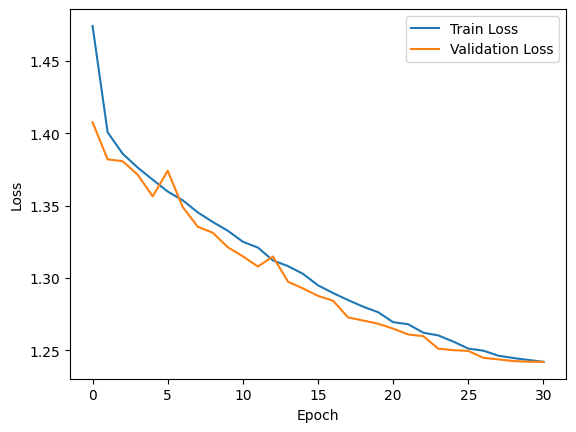

Improved result: acc 0.470, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=30, power=1)
epoch: 30
<class 'torch.optim.lr_scheduler.PolynomialLR'>
Epoch   0 | Train Loss: 1.480 | Train Acc:  33.53%
Epoch   0 | Val Loss: 1.422 | Val Acc:  37.10%
learning rate: [0.0009344444444444444]
Epoch   1 | Train Loss: 1.403 | Train Acc:  38.18%
Epoch   1 | Val Loss: 1.388 | Val Acc:  38.92%
learning rate: [0.0008711111111111112]


KeyboardInterrupt: ignored

In [ ]:
trained_gcn = hyperparameter_tuning(model_gcn, strat_train, strat_val, scheduler_list, batch_size = 128)

In [ ]:
model_gat = GAT_lstm(cv19_graph_data_train.num_node_features,
                cv19_graph_data_train.num_classes*2,
                cv19_graph_data_train.num_classes, heads = 10).to(device)
print(model_gat)

GAT_lstm(
  (gat_list_1): ModuleList(
    (0-9): 10 x GATv2Conv(100, 10, heads=10)
  )
  (gat_list_2): ModuleList(
    (0-9): 10 x GATv2Conv(100, 10, heads=10)
  )
  (gat_list_3): ModuleList(
    (0-9): 10 x GATv2Conv(100, 10, heads=10)
  )
  (l_list): ModuleList(
    (0-9): 10 x Linear(in_features=100, out_features=1, bias=True)
  )
  (lstm): LSTM(100, 100)
  (classifier): Linear(in_features=10, out_features=5, bias=True)
)


0.001
[functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=300, power=2), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=100, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=75, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-06), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-07), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-08), functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>, max_lr=0.001, steps_per_epoch=103, epochs=300, anneal_strategy='cos')]
batch size: 256
<class 'torch.optim.lr_scheduler.PolynomialLR'>
99
Epoch   0 | Train Loss: 1.382 | Train Acc:  38.78%
Epoch   0 | Val Loss: 1.280 | Val Acc:  44.21%
learning rate: [0.0009933444444444445]
99
Epoch   1 | Train Loss: 1.235 | Train Acc:  46.89%
Epoch   1 | Val Loss: 1.198 | Val

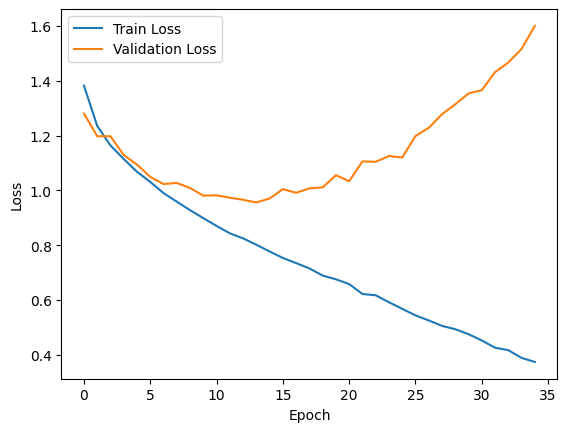

Improved result: acc 0.639, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=300, power=2)
epoch: 13
<class 'torch.optim.lr_scheduler.StepLR'>
99
Epoch   0 | Train Loss: 1.372 | Train Acc:  39.44%
Epoch   0 | Val Loss: 1.267 | Val Acc:  45.24%
learning rate: [0.001]
99
Epoch   1 | Train Loss: 1.236 | Train Acc:  47.19%
Epoch   1 | Val Loss: 1.208 | Val Acc:  47.68%
learning rate: [0.001]
99
Epoch   2 | Train Loss: 1.173 | Train Acc:  50.57%
Epoch   2 | Val Loss: 1.148 | Val Acc:  52.03%
learning rate: [0.001]
99
Epoch   3 | Train Loss: 1.122 | Train Acc:  53.46%
Epoch   3 | Val Loss: 1.110 | Val Acc:  54.49%
learning rate: [0.001]
99
Epoch   4 | Train Loss: 1.070 | Train Acc:  56.37%
Epoch   4 | Val Loss: 1.073 | Val Acc:  56.32%
learning rate: [0.001]
99
Epoch   5 | Train Loss: 1.032 | Train Acc:  58.47%
Epoch   5 | Val Loss: 1.046 | Val Acc:  58.04%
learning rate: [0.001]
99
Epoch   6 | Train Loss: 0.989 | Train Acc:  60.83%
Epoch   6 | Val L

In [ ]:
epochs = 300
# da rifare esperimenti col polinomial 2
# training information from stepLR (2) to CosineAnnealing
print(get_lr(model_gat.optimizer))
scheduler_list = build_scheduler_list(epochs=epochs,
                                      num_batches=(len(cv19_graph_data_train.data_list)//256) + 4)
print(scheduler_list)
trained_gat = hyperparameter_tuning(model_gat, cv19_graph_data_train,
                                    cv19_graph_data_val, scheduler_list,
                                    batch_size = 256, epochs = epochs)

0.001
[functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=300, power=1), functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=300, power=2), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=100, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=75, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-06), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-07), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-08), functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>, max_lr=0.001, steps_per_epoch=10, epochs=300, anneal_strategy='cos'), functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>, max_lr=0.001, steps_per_epoch=50, epochs=300, anneal_strategy='cos'), functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>

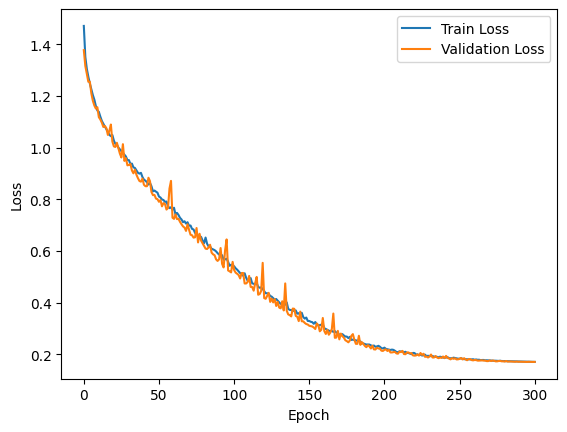

Improved result: acc 1.000, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=300, power=1)
epoch: 292
<class 'torch.optim.lr_scheduler.PolynomialLR'>
Epoch   0 | Train Loss: 1.478 | Train Acc:  33.35%
Epoch   0 | Val Loss: 1.384 | Val Acc:  38.78%
learning rate: [0.0009933444444444445]
Epoch   1 | Train Loss: 1.357 | Train Acc:  39.65%
Epoch   1 | Val Loss: 1.322 | Val Acc:  42.11%
learning rate: [0.0009867111111111111]
Epoch   2 | Train Loss: 1.308 | Train Acc:  42.70%
Epoch   2 | Val Loss: 1.288 | Val Acc:  43.89%
learning rate: [0.0009801000000000002]
Epoch   3 | Train Loss: 1.274 | Train Acc:  44.38%
Epoch   3 | Val Loss: 1.251 | Val Acc:  45.90%
learning rate: [0.0009735111111111113]
Epoch   4 | Train Loss: 1.250 | Train Acc:  45.90%
Epoch   4 | Val Loss: 1.233 | Val Acc:  47.17%
learning rate: [0.0009669444444444444]
Epoch   5 | Train Loss: 1.226 | Train Acc:  47.36%
Epoch   5 | Val Loss: 1.206 | Val Acc:  48.38%
learning rate: [0.0009604

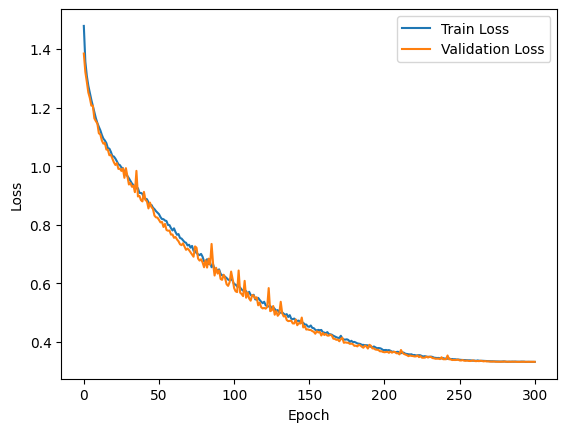

<class 'torch.optim.lr_scheduler.StepLR'>
Epoch   0 | Train Loss: 1.480 | Train Acc:  33.02%
Epoch   0 | Val Loss: 1.390 | Val Acc:  38.50%
learning rate: [0.001]
Epoch   1 | Train Loss: 1.360 | Train Acc:  39.78%
Epoch   1 | Val Loss: 1.328 | Val Acc:  41.67%
learning rate: [0.001]
Epoch   2 | Train Loss: 1.309 | Train Acc:  42.64%
Epoch   2 | Val Loss: 1.281 | Val Acc:  44.12%
learning rate: [0.001]
Epoch   3 | Train Loss: 1.277 | Train Acc:  44.43%
Epoch   3 | Val Loss: 1.254 | Val Acc:  45.77%
learning rate: [0.001]
Epoch   4 | Train Loss: 1.249 | Train Acc:  45.86%
Epoch   4 | Val Loss: 1.237 | Val Acc:  46.88%
learning rate: [0.001]
Epoch   5 | Train Loss: 1.230 | Train Acc:  47.09%
Epoch   5 | Val Loss: 1.209 | Val Acc:  48.23%
learning rate: [0.001]
Epoch   6 | Train Loss: 1.206 | Train Acc:  48.33%
Epoch   6 | Val Loss: 1.185 | Val Acc:  49.62%
learning rate: [0.001]
Epoch   7 | Train Loss: 1.183 | Train Acc:  49.33%
Epoch   7 | Val Loss: 1.168 | Val Acc:  50.79%
learning rate

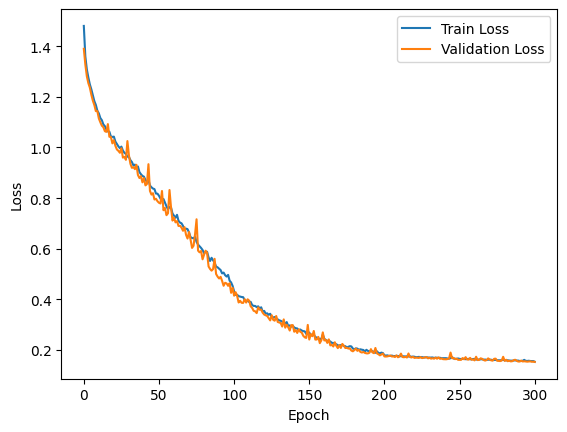

Improved result: acc 1.000, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=100, gamma=0.5)
epoch: 250
<class 'torch.optim.lr_scheduler.StepLR'>
Epoch   0 | Train Loss: 1.471 | Train Acc:  33.58%
Epoch   0 | Val Loss: 1.381 | Val Acc:  39.08%
learning rate: [0.001]
Epoch   1 | Train Loss: 1.356 | Train Acc:  40.08%
Epoch   1 | Val Loss: 1.325 | Val Acc:  41.96%
learning rate: [0.001]
Epoch   2 | Train Loss: 1.310 | Train Acc:  42.40%
Epoch   2 | Val Loss: 1.290 | Val Acc:  43.44%
learning rate: [0.001]
Epoch   3 | Train Loss: 1.275 | Train Acc:  44.70%
Epoch   3 | Val Loss: 1.262 | Val Acc:  45.11%
learning rate: [0.001]
Epoch   4 | Train Loss: 1.248 | Train Acc:  46.08%
Epoch   4 | Val Loss: 1.228 | Val Acc:  47.30%
learning rate: [0.001]
Epoch   5 | Train Loss: 1.228 | Train Acc:  47.14%
Epoch   5 | Val Loss: 1.210 | Val Acc:  48.19%
learning rate: [0.001]
Epoch   6 | Train Loss: 1.206 | Train Acc:  48.16%
Epoch   6 | Val Loss: 1.190 | Val Acc:  49.

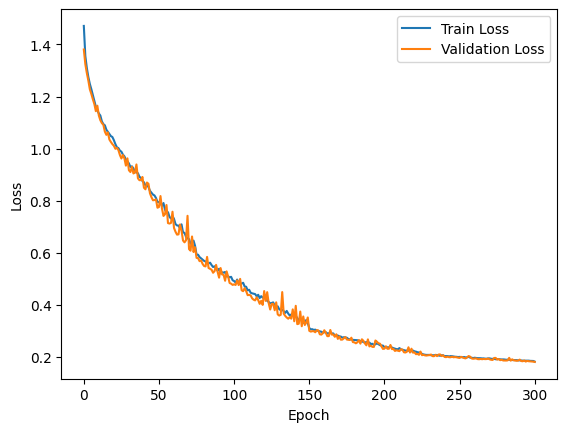

<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
Epoch   0 | Train Loss: 1.476 | Train Acc:  33.53%
Epoch   0 | Val Loss: 1.383 | Val Acc:  38.92%
learning rate: [0.0009999726120980734]
Epoch   1 | Train Loss: 1.357 | Train Acc:  40.22%
Epoch   1 | Val Loss: 1.323 | Val Acc:  42.20%
learning rate: [0.0009998904513956854]
Epoch   2 | Train Loss: 1.310 | Train Acc:  42.74%
Epoch   2 | Val Loss: 1.286 | Val Acc:  43.94%
learning rate: [0.0009997535269026829]
Epoch   3 | Train Loss: 1.277 | Train Acc:  44.47%
Epoch   3 | Val Loss: 1.261 | Val Acc:  45.32%
learning rate: [0.0009995618536343797]
Epoch   4 | Train Loss: 1.258 | Train Acc:  44.99%
Epoch   4 | Val Loss: 1.234 | Val Acc:  46.86%
learning rate: [0.0009993154526099096]
Epoch   5 | Train Loss: 1.232 | Train Acc:  46.88%
Epoch   5 | Val Loss: 1.213 | Val Acc:  48.00%
learning rate: [0.0009990143508499217]
Epoch   6 | Train Loss: 1.212 | Train Acc:  48.10%
Epoch   6 | Val Loss: 1.197 | Val Acc:  48.77%
learning rate: [0.000998658

In [ ]:
# training information for polynomialLR to stepLR
epochs = 300
print(get_lr(model_gat.optimizer))
scheduler_list = build_scheduler_list(epochs=epochs)
print(scheduler_list)
trained_gat = hyperparameter_tuning(model_gat, strat_train, strat_val, scheduler_list, batch_size = 256, epochs = epochs)

In [ ]:
model_gat = GAT_bilstm(cv19_graph_data_train.num_node_features,
                cv19_graph_data_train.num_classes*2,
                cv19_graph_data_train.num_classes, heads = 10).to(device)
print(model_gat)

GAT_bilstm(
  (gat_list_1): ModuleList(
    (0-9): 10 x GATv2Conv(200, 20, heads=10)
  )
  (gat_list_2): ModuleList(
    (0-9): 10 x GATv2Conv(200, 20, heads=10)
  )
  (gat_list_3): ModuleList(
    (0-9): 10 x GATv2Conv(200, 20, heads=10)
  )
  (l_list): ModuleList(
    (0-9): 10 x Linear(in_features=200, out_features=1, bias=True)
  )
  (lstm): LSTM(100, 100, bidirectional=True)
  (classifier): Linear(in_features=10, out_features=5, bias=True)
)


0.001
[functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=300, power=2), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=100, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=75, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-06), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-07), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-08), functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>, max_lr=0.001, steps_per_epoch=103, epochs=300, anneal_strategy='cos')]
batch size: 256
<class 'torch.optim.lr_scheduler.PolynomialLR'>
99
Epoch   0 | Train Loss: 1.375 | Train Acc:  39.32%
Epoch   0 | Val Loss: 1.270 | Val Acc:  45.71%
learning rate: [0.0009933444444444445]
99
Epoch   1 | Train Loss: 1.226 | Train Acc:  48.01%
Epoch   1 | Val Loss: 1.191 | Val

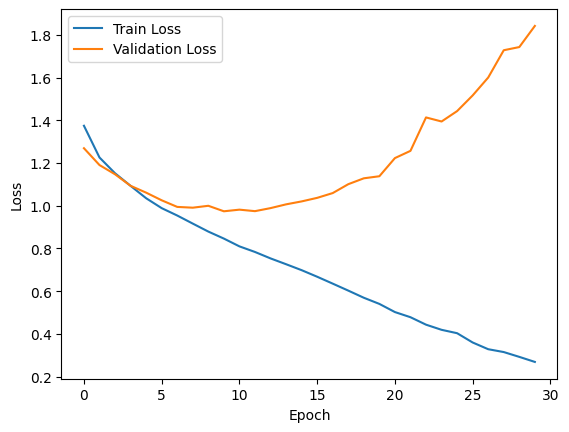

Improved result: acc 0.641, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=300, power=2)
epoch: 12
<class 'torch.optim.lr_scheduler.StepLR'>
99
Epoch   0 | Train Loss: 1.379 | Train Acc:  39.50%
Epoch   0 | Val Loss: 1.260 | Val Acc:  45.93%
learning rate: [0.001]
99
Epoch   1 | Train Loss: 1.231 | Train Acc:  47.52%
Epoch   1 | Val Loss: 1.195 | Val Acc:  48.91%
learning rate: [0.001]
99
Epoch   2 | Train Loss: 1.155 | Train Acc:  51.45%
Epoch   2 | Val Loss: 1.147 | Val Acc:  51.96%
learning rate: [0.001]
99
Epoch   3 | Train Loss: 1.090 | Train Acc:  55.40%
Epoch   3 | Val Loss: 1.092 | Val Acc:  54.96%
learning rate: [0.001]
99
Epoch   4 | Train Loss: 1.035 | Train Acc:  58.28%
Epoch   4 | Val Loss: 1.060 | Val Acc:  57.34%
learning rate: [0.001]
99
Epoch   5 | Train Loss: 0.989 | Train Acc:  61.21%
Epoch   5 | Val Loss: 1.017 | Val Acc:  59.31%
learning rate: [0.001]
99
Epoch   6 | Train Loss: 0.937 | Train Acc:  63.84%
Epoch   6 | Val L

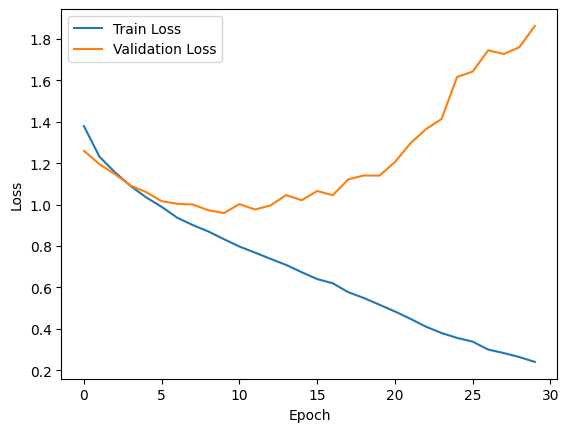

<class 'torch.optim.lr_scheduler.StepLR'>
99
Epoch   0 | Train Loss: 1.392 | Train Acc:  38.00%
Epoch   0 | Val Loss: 1.265 | Val Acc:  46.39%
learning rate: [0.001]
99
Epoch   1 | Train Loss: 1.228 | Train Acc:  47.57%
Epoch   1 | Val Loss: 1.193 | Val Acc:  50.33%
learning rate: [0.001]
99
Epoch   2 | Train Loss: 1.157 | Train Acc:  51.50%
Epoch   2 | Val Loss: 1.146 | Val Acc:  52.08%
learning rate: [0.001]
99
Epoch   3 | Train Loss: 1.100 | Train Acc:  54.59%
Epoch   3 | Val Loss: 1.097 | Val Acc:  55.01%
learning rate: [0.001]
99
Epoch   4 | Train Loss: 1.048 | Train Acc:  57.24%
Epoch   4 | Val Loss: 1.057 | Val Acc:  57.25%
learning rate: [0.001]
99
Epoch   5 | Train Loss: 1.000 | Train Acc:  60.48%
Epoch   5 | Val Loss: 1.028 | Val Acc:  59.54%
learning rate: [0.001]
99
Epoch   6 | Train Loss: 0.952 | Train Acc:  63.16%
Epoch   6 | Val Loss: 1.022 | Val Acc:  59.11%
learning rate: [0.001]
99
Epoch   7 | Train Loss: 0.923 | Train Acc:  64.46%
Epoch   7 | Val Loss: 0.999 | Val Ac

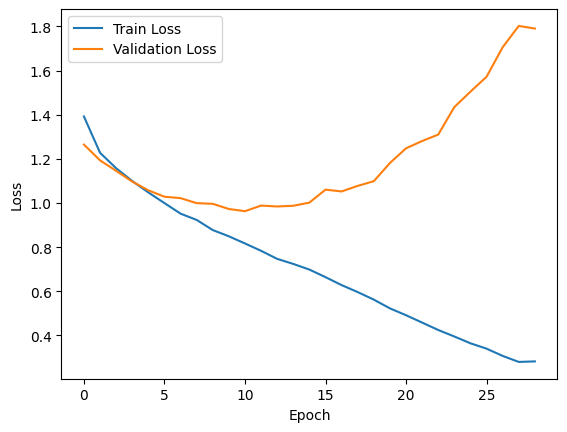

<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
99
Epoch   0 | Train Loss: 1.380 | Train Acc:  39.06%
Epoch   0 | Val Loss: 1.281 | Val Acc:  44.65%
learning rate: [0.0009999726120980734]
99
Epoch   1 | Train Loss: 1.224 | Train Acc:  48.16%
Epoch   1 | Val Loss: 1.193 | Val Acc:  49.28%
learning rate: [0.0009998904513956854]
99
Epoch   2 | Train Loss: 1.154 | Train Acc:  51.47%
Epoch   2 | Val Loss: 1.131 | Val Acc:  53.53%
learning rate: [0.0009997535269026829]
99
Epoch   3 | Train Loss: 1.092 | Train Acc:  55.17%
Epoch   3 | Val Loss: 1.100 | Val Acc:  55.08%
learning rate: [0.0009995618536343797]
99
Epoch   4 | Train Loss: 1.035 | Train Acc:  58.44%
Epoch   4 | Val Loss: 1.083 | Val Acc:  56.07%
learning rate: [0.0009993154526099096]
99
Epoch   5 | Train Loss: 0.999 | Train Acc:  60.74%
Epoch   5 | Val Loss: 1.028 | Val Acc:  59.06%
learning rate: [0.0009990143508499217]
99
Epoch   6 | Train Loss: 0.945 | Train Acc:  63.43%
Epoch   6 | Val Loss: 0.996 | Val Acc:  61.33%
learni

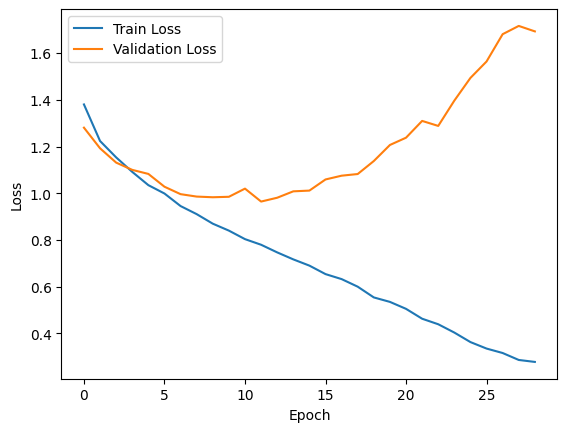

Improved result: acc 0.643, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-06)
epoch: 13
<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
99
Epoch   0 | Train Loss: 1.377 | Train Acc:  39.17%
Epoch   0 | Val Loss: 1.263 | Val Acc:  45.59%
learning rate: [0.0009999725874242878]
99
Epoch   1 | Train Loss: 1.228 | Train Acc:  47.80%
Epoch   1 | Val Loss: 1.194 | Val Acc:  49.73%
learning rate: [0.000999890352703249]
99
Epoch   2 | Train Loss: 1.156 | Train Acc:  51.57%
Epoch   2 | Val Loss: 1.135 | Val Acc:  53.04%
learning rate: [0.0009997533048548475]
99
Epoch   3 | Train Loss: 1.099 | Train Acc:  54.77%
Epoch   3 | Val Loss: 1.103 | Val Acc:  53.96%
learning rate: [0.0009995614589079242]
99
Epoch   4 | Train Loss: 1.043 | Train Acc:  58.08%
Epoch   4 | Val Loss: 1.084 | Val Acc:  55.18%
learning rate: [0.0009993148359005491]
99
Epoch   5 | Train Loss: 1.004 | Train Acc:  60.65%
Epoch   5 | Val Loss: 1.019 | Val Acc:  59.59%

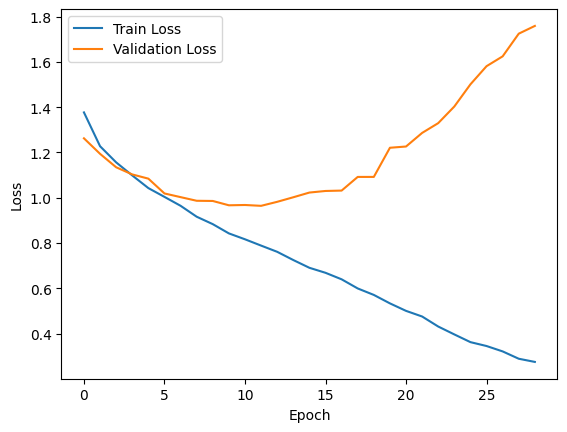

<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
99
Epoch   0 | Train Loss: 1.377 | Train Acc:  39.50%
Epoch   0 | Val Loss: 1.284 | Val Acc:  44.68%
learning rate: [0.0009999725849569093]
99
Epoch   1 | Train Loss: 1.223 | Train Acc:  47.78%
Epoch   1 | Val Loss: 1.212 | Val Acc:  47.98%
learning rate: [0.0009998903428340053]
99
Epoch   2 | Train Loss: 1.151 | Train Acc:  51.79%
Epoch   2 | Val Loss: 1.137 | Val Acc:  53.13%
learning rate: [0.0009997532826500639]
99
Epoch   3 | Train Loss: 1.089 | Train Acc:  55.56%
Epoch   3 | Val Loss: 1.086 | Val Acc:  55.57%
learning rate: [0.0009995614194352785]
99
Epoch   4 | Train Loss: 1.039 | Train Acc:  58.44%
Epoch   4 | Val Loss: 1.056 | Val Acc:  57.12%
learning rate: [0.000999314774229613]
99
Epoch   5 | Train Loss: 0.998 | Train Acc:  60.39%
Epoch   5 | Val Loss: 1.043 | Val Acc:  58.25%
learning rate: [0.0009990133740804936]
99
Epoch   6 | Train Loss: 0.948 | Train Acc:  63.44%
Epoch   6 | Val Loss: 1.009 | Val Acc:  60.83%
learnin

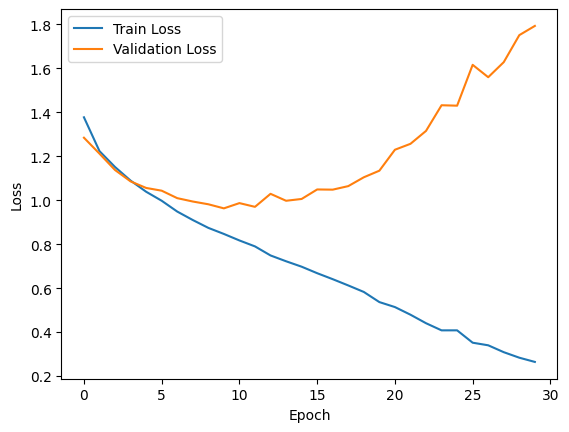

<class 'torch.optim.lr_scheduler.OneCycleLR'>
99
Epoch   0 | Train Loss: 1.553 | Train Acc:  29.37%
Epoch   0 | Val Loss: 1.531 | Val Acc:  31.33%
learning rate: [4.027567897599423e-05]
99
Epoch   1 | Train Loss: 1.506 | Train Acc:  32.15%
Epoch   1 | Val Loss: 1.488 | Val Acc:  33.40%
learning rate: [4.110239924190267e-05]
99
Epoch   2 | Train Loss: 1.464 | Train Acc:  34.57%
Epoch   2 | Val Loss: 1.442 | Val Acc:  36.41%
learning rate: [4.24792111752407e-05]
99
Epoch   3 | Train Loss: 1.407 | Train Acc:  37.93%
Epoch   3 | Val Loss: 1.381 | Val Acc:  39.25%
learning rate: [4.440453328390852e-05]
99
Epoch   4 | Train Loss: 1.348 | Train Acc:  41.21%
Epoch   4 | Val Loss: 1.328 | Val Acc:  42.05%
learning rate: [4.687615402279219e-05]
99
Epoch   5 | Train Loss: 1.312 | Train Acc:  43.34%
Epoch   5 | Val Loss: 1.311 | Val Acc:  43.32%
learning rate: [4.989123433408191e-05]
99
Epoch   6 | Train Loss: 1.290 | Train Acc:  44.51%
Epoch   6 | Val Loss: 1.290 | Val Acc:  43.51%
learning rate:

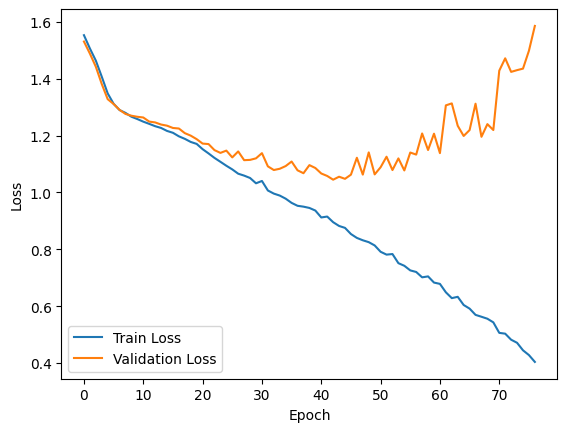

In [ ]:
epochs = 300
# da rifare esperimenti col polinomial 2
# training information from stepLR (2) to CosineAnnealing
print(get_lr(model_gat.optimizer))
scheduler_list = build_scheduler_list(epochs=epochs,
                                      num_batches=(len(cv19_graph_data_train.data_list)//256) + 4)
print(scheduler_list)
trained_gat = hyperparameter_tuning(model_gat, cv19_graph_data_train,
                                    cv19_graph_data_val, scheduler_list,
                                    batch_size = 256, epochs = epochs)

In [ ]:
print(cv19_graph_data_train)

Dataset_from_sentences(25534)


In [14]:
model_gat = GAT_lstm(cv19_graph_data_train.num_node_features,
                cv19_graph_data_train.num_classes*2,
                cv19_graph_data_train.num_classes, heads = 10).to(device)
print(model_gat)

GAT_lstm(
  (gat_list_1): ModuleList(
    (0-9): 10 x GATv2Conv(100, 10, heads=10)
  )
  (gat_list_2): ModuleList(
    (0-9): 10 x GATv2Conv(100, 10, heads=10)
  )
  (gat_list_3): ModuleList(
    (0-9): 10 x GATv2Conv(100, 10, heads=10)
  )
  (l_list): ModuleList(
    (0-9): 10 x Linear(in_features=100, out_features=1, bias=True)
  )
  (lstm): LSTM(100, 100)
  (classifier): Linear(in_features=10, out_features=5, bias=True)
)


0.001
[functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=100, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-08)]
batch size: 256
<class 'torch.optim.lr_scheduler.StepLR'>
99
Epoch   0 | Train Loss: 1.399 | Train Acc:  37.82%
Epoch   0 | Val Loss: 1.275 | Val Acc:  44.96%
learning rate: [0.001]
elapsed time: 46.10
99
Epoch   1 | Train Loss: 1.242 | Train Acc:  46.90%
Epoch   1 | Val Loss: 1.214 | Val Acc:  48.50%
learning rate: [0.001]
elapsed time: 42.50
99
Epoch   2 | Train Loss: 1.181 | Train Acc:  49.99%
Epoch   2 | Val Loss: 1.193 | Val Acc:  49.46%
learning rate: [0.001]
elapsed time: 42.60
99
Epoch   3 | Train Loss: 1.129 | Train Acc:  52.81%
Epoch   3 | Val Loss: 1.121 | Val Acc:  53.45%
learning rate: [0.001]
elapsed time: 42.21
99
Epoch   4 | Train Loss: 1.076 | Train Acc:  55.99%
Epoch   4 | Val Loss: 1.097 | Val Acc:  55.57%
learning rate: [0.001]
elapsed time: 42.50
99
Epoch   5 | Train Loss: 1

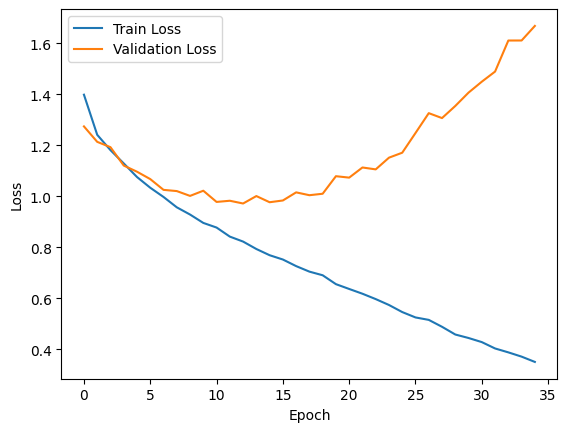

Improved result: acc 0.637, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=100, gamma=0.5)
epoch: 17
<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
99
Epoch   0 | Train Loss: 1.401 | Train Acc:  38.15%
Epoch   0 | Val Loss: 1.278 | Val Acc:  45.01%
learning rate: [0.0009999725849569093]
elapsed time: 43.04
99
Epoch   1 | Train Loss: 1.246 | Train Acc:  46.79%
Epoch   1 | Val Loss: 1.223 | Val Acc:  47.12%
learning rate: [0.0009998903428340053]
elapsed time: 42.09
99
Epoch   2 | Train Loss: 1.181 | Train Acc:  49.98%
Epoch   2 | Val Loss: 1.159 | Val Acc:  51.61%
learning rate: [0.0009997532826500639]
elapsed time: 44.56
99
Epoch   3 | Train Loss: 1.129 | Train Acc:  53.00%
Epoch   3 | Val Loss: 1.129 | Val Acc:  53.27%
learning rate: [0.0009995614194352785]
elapsed time: 42.43
99
Epoch   4 | Train Loss: 1.076 | Train Acc:  55.99%
Epoch   4 | Val Loss: 1.086 | Val Acc:  55.53%
learning rate: [0.000999314774229613]
elapsed time: 41.98
99
Epoch   

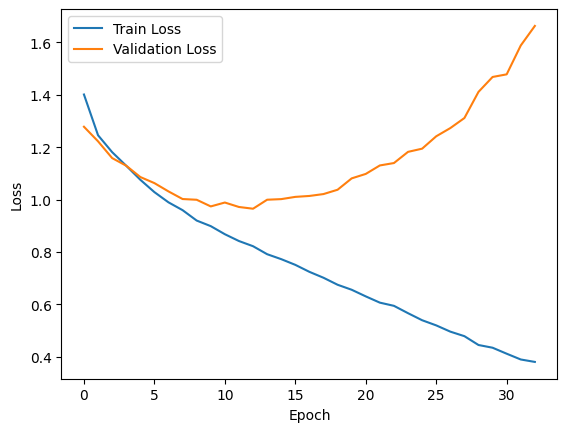

In [15]:
epochs = 300
# da rifare esperimenti col polinomial 2
# training information from stepLR (2) to CosineAnnealing
print(get_lr(model_gat.optimizer))
scheduler_list = build_scheduler_list(epochs=epochs,
                                      num_batches=(len(cv19_graph_data_train.data_list)//256) + 4)
print(scheduler_list)
trained_gat = hyperparameter_tuning(model_gat, cv19_graph_data_train,
                                    cv19_graph_data_val, scheduler_list,
                                    batch_size = 256, epochs = epochs)

In [ ]:
def eval_model(model, loader_val, criterion, batch_size):
  mean_loss_val = 0
  mean_acc_val = 0
  #model.eval()
  idx_wrong_samples = np.array([])
  with torch.no_grad():
      for i, batch in tqdm(enumerate(loader_val)):
        out = model(batch.x.to(device), batch.edge_index.to(device), batch.batch.to(device))
        loss_val = criterion(out, batch.y.long().to(device))
        mean_loss_val += loss_val.item()
        acc_val = accuracy(out.argmax(dim=1), batch.y.to(device))
        mean_acc_val += acc_val
        curr_idx_wrong_samples = (batch_size * i) + np.flatnonzero(out.argmax(dim=1) != batch.y.to(device))
        idx_wrong_samples = np.concatenate((idx_wrong_samples, curr_idx_wrong_samples))
        #visualize_embedding(embed, batch.y, epoch, loss_val)
      mean_loss_val /= (i + 1)
      mean_acc_val /= (i + 1)
  return mean_loss_val, mean_acc_val, idx_wrong_samples

In [ ]:
batch_size = 64
trained_gat_model = trained_gat[1]
loader_test = DataLoader(cv19_graph_data_test.data_list, batch_size=batch_size, shuffle=False)
criterion = torch.nn.CrossEntropyLoss(label_smoothing = 0.01)
mean_loss_test, mean_acc_test = eval_model(trained_gat_model, loader_test, criterion, batch_size)

125it [00:10, 11.50it/s]


In [ ]:
print(f'Test loss: {mean_loss_test}')
print(f'Test accuracy: {mean_acc_test}')

Test loss: 0.9703735203742981
Test accuracy: 0.6388409090042114
